##### Steps for reading in dataset (following download), initial QC, dim reduction/clustering and saving out the myeloid cluster for **GSE167297**

file previously downloaded:
GSE167297_RAW.tar

unzipped using 
``` bash
gunzip /scratch/user/s4436039/scdata/GSE131907/GSE131907_Lung_Cancer_raw_UMI_matrix.rds.gz
```

This gives the following file: 
* GSE131907_Lung_Cancer_raw_UMI_matrix.rds

##### Samples are from lung adenocarcinoma (LUAD)
##### All patients together in one object, can distinguish samples by suffix on barcode (PMID 32385277 for details). 
* LUNG_N01, LUNG_N06, LUNG_N08, LUNG_N09, LUNG_N18, LUNG_N19, LUNG_N20, LUNG_N28, LUNG_N30, LUNG_N31, LUNG_N34 --> normal lung (**USE**)
* LUNG_T06, LUNG_T08, LUNG_T09, LUNG_T18, LUNG_T19, LUNG_T20, LUNG_T25, LUNG_T28, LUNG_T30, LUNG_T31, LUNG_T34 --> early stage tumour lung (**USE**)
* EBUS_06, EBUS_28, EBUS_49, BRONCHO_58 --> advanced stage tumour lung (**USE**)
* EBUS_10, BRONCHO_11, EBUS_12, EBUS_13, EBUS_15, EBUS_19, EBUS_51 --> LN mets (**USE**)
* LN_01, LN_02, LN_03, LN_04, LN_05, LN_06, LN_07, LN_08, LN_11, LN_12 --> normal LN (DONT USE)
* EFFUSION_06, EFFUSION_11, EFFUSION_12, EFFUSION_13, EFFUSION_64 --> pleural effusion (DONT USE)
* NS_02, NS_03, NS_04, NS_06, NS_07, NS_12, NS_13, NS_16, NS_17, NS_19 --> brain mets (**USE**)




In [1]:
#set wd
getwd()
setwd('/scratch/user/s4436039/scdata/GSE131907')
getwd()

[1] "/scratch/user/s4436039/Nikita-project"

[1] "/scratch/user/s4436039/scdata/GSE131907"

In [2]:
#Load packages
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [3]:
#load all datasets
LUAD.data <- readRDS("GSE131907_Lung_Cancer_raw_UMI_matrix.rds")

In [4]:
head(colnames(LUAD.data))
#can see below that patients can be distinguished by suffix on barcode, see top for summary of samples

[1] "AAACCTGAGAAACCGC_LN_05"    "AAACCTGAGAAACGCC_NS_13"   
[3] "AAACCTGAGAAGGTGA_LUNG_N18" "AAACCTGAGACAAAGG_LUNG_N18"
[5] "AAACCTGAGACATAAC_LN_04"    "AAACCTGAGACCTTTG_LUNG_N30"

In [5]:
#create seurat object for sample
LUAD <- CreateSeuratObject(counts = LUAD.data, project = "GSE131907", min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


In [6]:
head(LUAD@meta.data)

orig.ident nCount_RNA nFeature_RNA
AAACCTGAGAAACCGC_LN_05    GSE131907  19928      1690        
AAACCTGAGAAACGCC_NS_13    GSE131907   1382       611        
AAACCTGAGAAGGTGA_LUNG_N18 GSE131907   3214      1113        
AAACCTGAGACAAAGG_LUNG_N18 GSE131907   2990      1100        
AAACCTGAGACATAAC_LN_04    GSE131907   3880       948        
AAACCTGAGACCTTTG_LUNG_N30 GSE131907   2565       847

In [7]:
#extract the cell barcodes
bc_meta <- row.names(LUAD@meta.data)

In [8]:
# split each cell barcode by the separator, which is _. this will return a list, each with 3 entries
bc_meta <- strsplit(bc_meta, "_")

In [9]:
bc_meta[[1]]

[1] "AAACCTGAGAAACCGC" "LN"               "05"

In [11]:
# collapse the list to make a 3 column dataframe
bc_meta <- as.data.frame(do.call(rbind, bc_meta))

In [14]:
head(bc_meta)

V1               V2   V3 
1 AAACCTGAGAAACCGC LN   05 
2 AAACCTGAGAAACGCC NS   13 
3 AAACCTGAGAAGGTGA LUNG N18
4 AAACCTGAGACAAAGG LUNG N18
5 AAACCTGAGACATAAC LN   04 
6 AAACCTGAGACCTTTG LUNG N30

In [21]:
# merge the columns we want
LUAD@meta.data$sample_meta <- paste0(bc_meta[,2], "_", bc_meta[,3])

In [22]:
head(LUAD@meta.data)

orig.ident nCount_RNA nFeature_RNA sample_meta
AAACCTGAGAAACCGC_LN_05    GSE131907  19928      1690         LN_05      
AAACCTGAGAAACGCC_NS_13    GSE131907   1382       611         NS_13      
AAACCTGAGAAGGTGA_LUNG_N18 GSE131907   3214      1113         LUNG_N18   
AAACCTGAGACAAAGG_LUNG_N18 GSE131907   2990      1100         LUNG_N18   
AAACCTGAGACATAAC_LN_04    GSE131907   3880       948         LN_04      
AAACCTGAGACCTTTG_LUNG_N30 GSE131907   2565       847         LUNG_N30

In [23]:
#see what samples I have 
table(LUAD$sample_meta)


 BRONCHO_11  BRONCHO_58     EBUS_06     EBUS_10     EBUS_12     EBUS_13 
       3178        2813        2303        5144        3115        3550 
    EBUS_15     EBUS_19     EBUS_28     EBUS_49     EBUS_51 EFFUSION_06 
       1105        2112        5182        1775        3275        4884 
EFFUSION_11 EFFUSION_12 EFFUSION_13 EFFUSION_64       LN_01       LN_02 
       2943        4224        4441        3812        3626        3178 
      LN_03       LN_04       LN_05       LN_06       LN_07       LN_08 
       3013        3092        3087        2936        5713        4395 
      LN_11       LN_12    LUNG_N01    LUNG_N06    LUNG_N08    LUNG_N09 
       3788        4618        3194        2839        3380        2528 
   LUNG_N18    LUNG_N19    LUNG_N20    LUNG_N28    LUNG_N30    LUNG_N31 
       4628        3870        5798        3411        3884        4241 
   LUNG_N34    LUNG_T06    LUNG_T08    LUNG_T09    LUNG_T18    LUNG_T19 
       5222        3426        3765        3840   

# need to edit to take in to account some patients have matched tissues

Giving all samples my own patient id

Normal lung: 
* LUNG_N01 --> N1
* LUNG_N06 --> N2
* LUNG_N08 --> N3
* LUNG_N09 --> N4
* LUNG_N18 --> N5
* LUNG_N19 --> N6
* LUNG_N20 --> N7
* LUNG_N28 --> N8
* LUNG_N30 --> N9
* LUNG_N31 --> N10
* LUNG_N34 --> N11

Tumour:
* LUNG_T06 --> T1
* LUNG_T08 --> T2
* LUNG_T09 --> T3
* LUNG_T18 --> T4
* LUNG_T19 --> T5
* LUNG_T20 --> T6
* LUNG_T25 --> T7
* LUNG_T28 --> T8
* LUNG_T30 --> T9
* LUNG_T31 --> T10
* LUNG_T34 --> T11
* EBUS_06 -->  T12
* EBUS_28 --> T13
* EBUS_49 --> T14
* BRONCHO_58 --> T15

LN mets
* EBUS_10 --> L1
* BRONCHO_11 --> L2 
* EBUS_12 --> L3
* EBUS_13 --> L4
* EBUS_15 --> L5
* EBUS_19 --> L6
* EBUS_51 --> L7

Brain mets
* NS_02 --> B1
* NS_03 --> B2
* NS_04 --> B3
* NS_06 --> B4
* NS_07 --> B5
* NS_12 --> B6
* NS_13 --> B7
* NS_16 --> B8
* NS_17 --> B9
* NS_19 --> B10

Other
* LN_01, LN_02, LN_03, LN_04, LN_05, LN_06, LN_07, LN_08, LN_11, LN_12 --> normal LN (**DONT USE**)
* EFFUSION_06, EFFUSION_11, EFFUSION_12, EFFUSION_13, EFFUSION_64 --> pleural effusion (**DONT USE**)

In [26]:
#split in to seperate seurat objects per sample
N1 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N01"))
N2 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N06"))
N3 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N08"))
N4 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N09"))
N5 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N18"))
N6 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N19"))
N7 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N20"))
N8 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N28"))
N9 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N30"))
N10 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N31"))
N11 <- subset(LUAD, subset = sample_meta %in% c("LUNG_N34"))

T1 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T06"))
T2 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T08"))
T3 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T09"))
T4 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T18"))
T5 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T19"))
T6 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T20"))
T7 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T25"))
T8 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T28"))
T9 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T30"))
T10 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T31"))
T11 <- subset(LUAD, subset = sample_meta %in% c("LUNG_T34"))
T12 <- subset(LUAD, subset = sample_meta %in% c("EBUS_06"))
T13 <- subset(LUAD, subset = sample_meta %in% c("EBUS_28"))
T14 <- subset(LUAD, subset = sample_meta %in% c("EBUS_49"))
T15 <- subset(LUAD, subset = sample_meta %in% c("BRONCHO_58"))

L1 <- subset(LUAD, subset = sample_meta %in% c("EBUS_10"))
L2 <- subset(LUAD, subset = sample_meta %in% c("BRONCHO_11"))
L3 <- subset(LUAD, subset = sample_meta %in% c("EBUS_12"))
L4 <- subset(LUAD, subset = sample_meta %in% c("EBUS_13"))
L5 <- subset(LUAD, subset = sample_meta %in% c("EBUS_15"))
L6 <- subset(LUAD, subset = sample_meta %in% c("EBUS_19"))
L7 <- subset(LUAD, subset = sample_meta %in% c("EBUS_51"))

B1 <- subset(LUAD, subset = sample_meta %in% c("NS_02"))
B2 <- subset(LUAD, subset = sample_meta %in% c("NS_03"))
B3 <- subset(LUAD, subset = sample_meta %in% c("NS_04"))
B4 <- subset(LUAD, subset = sample_meta %in% c("NS_06"))
B5 <- subset(LUAD, subset = sample_meta %in% c("NS_07"))
B6 <- subset(LUAD, subset = sample_meta %in% c("NS_12"))
B7 <- subset(LUAD, subset = sample_meta %in% c("NS_13"))
B8 <- subset(LUAD, subset = sample_meta %in% c("NS_16"))
B9 <- subset(LUAD, subset = sample_meta %in% c("NS_17"))
B10 <- subset(LUAD, subset = sample_meta %in% c("NS_19"))

In [27]:
table(N1$sample_meta)
table(N2$sample_meta)
table(N3$sample_meta)
table(N4$sample_meta)
table(N5$sample_meta)
table(N6$sample_meta)
table(N7$sample_meta)
table(N8$sample_meta)
table(N9$sample_meta)
table(N10$sample_meta)
table(N11$sample_meta)
table(T1$sample_meta)
table(T2$sample_meta)
table(T3$sample_meta)
table(T4$sample_meta)
table(T5$sample_meta)
table(T6$sample_meta)
table(T7$sample_meta)
table(T8$sample_meta)
table(T9$sample_meta)
table(T10$sample_meta)
table(T11$sample_meta)
table(T12$sample_meta)
table(T13$sample_meta)
table(T14$sample_meta)
table(T15$sample_meta)
table(L1$sample_meta)
table(L2$sample_meta)
table(L3$sample_meta)
table(L4$sample_meta)
table(L5$sample_meta)
table(L6$sample_meta)
table(L7$sample_meta)
table(B1$sample_meta)
table(B2$sample_meta)
table(B3$sample_meta)
table(B4$sample_meta)
table(B5$sample_meta)
table(B6$sample_meta)
table(B7$sample_meta)
table(B8$sample_meta)
table(B9$sample_meta)
table(B10$sample_meta)


LUNG_N01 
    3194 


LUNG_N06 
    2839 


LUNG_N08 
    3380 


LUNG_N09 
    2528 


LUNG_N18 
    4628 


LUNG_N19 
    3870 


LUNG_N20 
    5798 


LUNG_N28 
    3411 


LUNG_N30 
    3884 


LUNG_N31 
    4241 


LUNG_N34 
    5222 


LUNG_T06 
    3426 


LUNG_T08 
    3765 


LUNG_T09 
    3840 


LUNG_T18 
    3705 


LUNG_T19 
    4361 


LUNG_T20 
    4021 


LUNG_T25 
    4374 


LUNG_T28 
    4705 


LUNG_T30 
    4094 


LUNG_T31 
    5578 


LUNG_T34 
    3280 


EBUS_06 
   2303 


EBUS_28 
   5182 


EBUS_49 
   1775 


BRONCHO_58 
      2813 


EBUS_10 
   5144 


BRONCHO_11 
      3178 


EBUS_12 
   3115 


EBUS_13 
   3550 


EBUS_15 
   1105 


EBUS_19 
   2112 


EBUS_51 
   3275 


NS_02 
 2313 


NS_03 
 2990 


NS_04 
 1904 


NS_06 
 1070 


NS_07 
 5730 


NS_12 
 3182 


NS_13 
 4845 


NS_16 
 1317 


NS_17 
 2409 


NS_19 
 3300 

In [28]:
head(colnames(N2))
head(colnames(T14))
head(colnames(L4))
head(colnames(B2))

[1] "AAACCTGAGATGTGGC_LUNG_N06" "AAACCTGAGTGAAGTT_LUNG_N06"
[3] "AAACCTGCAAGAAGAG_LUNG_N06" "AAACCTGCAATGCCAT_LUNG_N06"
[5] "AAACCTGCACGGTTTA_LUNG_N06" "AAACCTGCAGACAAAT_LUNG_N06"

[1] "AAACCTGAGGCCCTTG_EBUS_49" "AAACCTGAGGTAAACT_EBUS_49"
[3] "AAACCTGCAATGAAAC_EBUS_49" "AAACCTGCATCTACGA_EBUS_49"
[5] "AAACCTGCATGCATGT_EBUS_49" "AAACGGGGTAAAGTCA_EBUS_49"

[1] "AAACCTGGTAGCGATG_EBUS_13" "AAACCTGGTAGCGCTC_EBUS_13"
[3] "AAACCTGGTCCAGTGC_EBUS_13" "AAACCTGGTTCTGGTA_EBUS_13"
[5] "AAACGGGAGCGAGAAA_EBUS_13" "AAACGGGCAGGAACGT_EBUS_13"

[1] "AAACCTGTCAAACAAG_NS_03" "AAACCTGTCACCATAG_NS_03" "AAACCTGTCCCACTTG_NS_03"
[4] "AAACGGGAGAGTACCG_NS_03" "AAACGGGAGATGTGTA_NS_03" "AAACGGGAGTAGGTGC_NS_03"

In [29]:
#Add dataset info to colnames
colnames(N1) <- paste0("GSE131907_Normal_N1_", colnames(N1))
colnames(N2) <- paste0("GSE131907_Normal_N2_", colnames(N2))
colnames(N3) <- paste0("GSE131907_Normal_N3_", colnames(N3))
colnames(N4) <- paste0("GSE131907_Normal_N4_", colnames(N4))
colnames(N5) <- paste0("GSE131907_Normal_N5_", colnames(N5))
colnames(N6) <- paste0("GSE131907_Normal_N6_", colnames(N6))
colnames(N7) <- paste0("GSE131907_Normal_N7_", colnames(N7))
colnames(N8) <- paste0("GSE131907_Normal_N8_", colnames(N8))
colnames(N9) <- paste0("GSE131907_Normal_N9_", colnames(N9))
colnames(N10) <- paste0("GSE131907_Normal_N10_", colnames(N10))
colnames(N11) <- paste0("GSE131907_Normal_N11_", colnames(N11))

colnames(T1) <- paste0("GSE131907_LUAD_Tu_T1_", colnames(T1))
colnames(T2) <- paste0("GSE131907_LUAD_Tu_T2_", colnames(T2))
colnames(T3) <- paste0("GSE131907_LUAD_Tu_T3_", colnames(T3))
colnames(T4) <- paste0("GSE131907_LUAD_Tu_T4_", colnames(T4))
colnames(T5) <- paste0("GSE131907_LUAD_Tu_T5_", colnames(T5))
colnames(T6) <- paste0("GSE131907_LUAD_Tu_T6_", colnames(T6))
colnames(T7) <- paste0("GSE131907_LUAD_Tu_T7_", colnames(T7))
colnames(T8) <- paste0("GSE131907_LUAD_Tu_T8_", colnames(T8))
colnames(T9) <- paste0("GSE131907_LUAD_Tu_T9_", colnames(T9))
colnames(T10) <- paste0("GSE131907_LUAD_Tu_T10_", colnames(T10))
colnames(T11) <- paste0("GSE131907_LUAD_Tu_T11_", colnames(T11))
colnames(T12) <- paste0("GSE131907_LUAD_Tu_T12_", colnames(T12))
colnames(T13) <- paste0("GSE131907_LUAD_Tu_T13_", colnames(T13))
colnames(T14) <- paste0("GSE131907_LUAD_Tu_T14_", colnames(T14))
colnames(T15) <- paste0("GSE131907_LUAD_Tu_T15_", colnames(T15))

colnames(L1) <- paste0("GSE131907_LUAD_LN_mets_L1_", colnames(L1))
colnames(L2) <- paste0("GSE131907_LUAD_LN_mets_L2_", colnames(L2))
colnames(L3) <- paste0("GSE131907_LUAD_LN_mets_L3_", colnames(L3))
colnames(L4) <- paste0("GSE131907_LUAD_LN_mets_L4_", colnames(L4))
colnames(L5) <- paste0("GSE131907_LUAD_LN_mets_L5_", colnames(L5))
colnames(L6) <- paste0("GSE131907_LUAD_LN_mets_L6_", colnames(L6))
colnames(L7) <- paste0("GSE131907_LUAD_LN_mets_L7_", colnames(L7))

colnames(B1) <- paste0("GSE131907_LUAD_Brain_mets_B1_", colnames(B1))
colnames(B2) <- paste0("GSE131907_LUAD_Brain_mets_B2_", colnames(B2))
colnames(B3) <- paste0("GSE131907_LUAD_Brain_mets_B3_", colnames(B3))
colnames(B4) <- paste0("GSE131907_LUAD_Brain_mets_B4_", colnames(B4))
colnames(B5) <- paste0("GSE131907_LUAD_Brain_mets_B5_", colnames(B5))
colnames(B6) <- paste0("GSE131907_LUAD_Brain_mets_B6_", colnames(B6))
colnames(B7) <- paste0("GSE131907_LUAD_Brain_mets_B7_", colnames(B7))
colnames(B8) <- paste0("GSE131907_LUAD_Brain_mets_B8_", colnames(B8))
colnames(B9) <- paste0("GSE131907_LUAD_Brain_mets_B9_", colnames(B9))
colnames(B10) <- paste0("GSE131907_LUAD_Brain_mets_B10_", colnames(B10))

In [7]:
head(colnames(LUAD.data))

[1] "GSE131907_LUAD_AAACCTGAGAAACCGC_LN_05"   
[2] "GSE131907_LUAD_AAACCTGAGAAACGCC_NS_13"   
[3] "GSE131907_LUAD_AAACCTGAGAAGGTGA_LUNG_N18"
[4] "GSE131907_LUAD_AAACCTGAGACAAAGG_LUNG_N18"
[5] "GSE131907_LUAD_AAACCTGAGACATAAC_LN_04"   
[6] "GSE131907_LUAD_AAACCTGAGACCTTTG_LUNG_N30"

In [8]:

#add metadata to sample
LUAD@meta.data$cancer_type <- "LUAD"

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


: 

: 

: 

In [21]:
LUAD
head(LUAD)
head(LUAD@meta.data) 

orig.ident nCount_RNA nFeature_RNA
GSE167297_GC_Pt2_Deep_AAACCTGAGATCCTGT-1 GSE167297   1834       661        
GSE167297_GC_Pt2_Deep_AAACCTGAGCGGATCA-1 GSE167297   2769       826        
GSE167297_GC_Pt2_Deep_AAACCTGCAAGGGTCA-1 GSE167297  13199      2670        
GSE167297_GC_Pt2_Deep_AAACCTGCAGGATCGA-1 GSE167297  11299      2129        
GSE167297_GC_Pt2_Deep_AAACCTGGTACTTCTT-1 GSE167297   3051       877        
GSE167297_GC_Pt2_Deep_AAACCTGGTCAATACC-1 GSE167297  11830       728        
                                         sample_type cancer_type         
GSE167297_GC_Pt2_Deep_AAACCTGAGATCCTGT-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt2_Deep_AAACCTGAGCGGATCA-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt2_Deep_AAACCTGCAAGGGTCA-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt2_Deep_AAACCTGCAGGATCGA-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt2_Deep_AAACCTGGTACTTCTT-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt2_Deep_AAACCTGGTCAATACC-1 tumour      Diffuse-type GC Deep
                                         patient_id sample_id            
GSE167297_GC_Pt2_Deep_AAACCTGAGATCCTGT-1 Pt_2       GSE167297_GC_Pt2_Deep
GSE167297_GC_Pt2_Deep_AAACCTGAGCGGATCA-1 Pt_2       GSE167297_GC_Pt2_Deep
GSE167297_GC_Pt2_Deep_AAACCTGCAAGGGTCA-1 Pt_2       GSE167297_GC_Pt2_Deep
GSE167297_GC_Pt2_Deep_AAACCTGCAGGATCGA-1 Pt_2       GSE167297_GC_Pt2_Deep
GSE167297_GC_Pt2_Deep_AAACCTGGTACTTCTT-1 Pt_2       GSE167297_GC_Pt2_Deep
GSE167297_GC_Pt2_Deep_AAACCTGGTCAATACC-1 Pt_2       GSE167297_GC_Pt2_Deep

orig.ident nCount_RNA nFeature_RNA
GSE167297_GC_Pt4_Norm_AAACGGGCACGACGAA-1 GSE167297   1136       386        
GSE167297_GC_Pt4_Norm_AAACGGGTCGGTGTTA-1 GSE167297   5488      1225        
GSE167297_GC_Pt4_Norm_AAAGATGCAAGTTCTG-1 GSE167297    700       417        
GSE167297_GC_Pt4_Norm_AAAGATGTCAGTTGAC-1 GSE167297   8663      2312        
GSE167297_GC_Pt4_Norm_AAAGTAGGTCGTCTTC-1 GSE167297  18295      3198        
GSE167297_GC_Pt4_Norm_AAATGCCCACAGATTC-1 GSE167297  23994       241        
                                         sample_type cancer_type patient_id
GSE167297_GC_Pt4_Norm_AAACGGGCACGACGAA-1 Healthy     Healthy     Pt_4      
GSE167297_GC_Pt4_Norm_AAACGGGTCGGTGTTA-1 Healthy     Healthy     Pt_4      
GSE167297_GC_Pt4_Norm_AAAGATGCAAGTTCTG-1 Healthy     Healthy     Pt_4      
GSE167297_GC_Pt4_Norm_AAAGATGTCAGTTGAC-1 Healthy     Healthy     Pt_4      
GSE167297_GC_Pt4_Norm_AAAGTAGGTCGTCTTC-1 Healthy     Healthy     Pt_4      
GSE167297_GC_Pt4_Norm_AAATGCCCACAGATTC-1 Healthy     Healthy     Pt_4      
                                         sample_id            
GSE167297_GC_Pt4_Norm_AAACGGGCACGACGAA-1 GSE167297_GC_Pt4_Norm
GSE167297_GC_Pt4_Norm_AAACGGGTCGGTGTTA-1 GSE167297_GC_Pt4_Norm
GSE167297_GC_Pt4_Norm_AAAGATGCAAGTTCTG-1 GSE167297_GC_Pt4_Norm
GSE167297_GC_Pt4_Norm_AAAGATGTCAGTTGAC-1 GSE167297_GC_Pt4_Norm
GSE167297_GC_Pt4_Norm_AAAGTAGGTCGTCTTC-1 GSE167297_GC_Pt4_Norm
GSE167297_GC_Pt4_Norm_AAATGCCCACAGATTC-1 GSE167297_GC_Pt4_Norm

### now need to find a way to set metadata from the barcode name

## here onwards not edited

In [22]:
#Merge seurat objects
GC <- merge(Pt1_N, y = c(Pt1_S, Pt1_D, Pt2_S, Pt2_D, Pt3_N, Pt3_S, Pt3_D, Pt4_N, Pt4_S, Pt4_D, Pt5_N, Pt5_S, Pt5_D), project = "GSE167297")

In [23]:
GC
head(GC@meta.data)
tail(GC@meta.data)

An object of class Seurat 
32738 features across 27073 samples within 1 assay 
Active assay: RNA (32738 features, 0 variable features)
 14 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14

orig.ident nCount_RNA nFeature_RNA
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 GSE167297   1037       368        
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 GSE167297    513       265        
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 GSE167297  91470      6344        
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 GSE167297    690       245        
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 GSE167297    584       278        
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 GSE167297   2073       602        
                                         sample_type cancer_type patient_id
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 Healthy     Healthy     Pt_1      
                                         sample_id            
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 GSE167297_GC_Pt1_Norm
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 GSE167297_GC_Pt1_Norm
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 GSE167297_GC_Pt1_Norm
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 GSE167297_GC_Pt1_Norm
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 GSE167297_GC_Pt1_Norm
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 GSE167297_GC_Pt1_Norm

orig.ident nCount_RNA nFeature_RNA
GSE167297_GC_Pt5_Deep_TTTATGCAGATCCCGC-1 GSE167297   585        226        
GSE167297_GC_Pt5_Deep_TTTCCTCAGTGGGATC-1 GSE167297  6365       1505        
GSE167297_GC_Pt5_Deep_TTTCCTCTCACGATGT-1 GSE167297  1728        717        
GSE167297_GC_Pt5_Deep_TTTGCGCCAACGCACC-1 GSE167297  1794        741        
GSE167297_GC_Pt5_Deep_TTTGCGCCAATACGCT-1 GSE167297  2061        717        
GSE167297_GC_Pt5_Deep_TTTGTCAGTCTTCGTC-1 GSE167297  3032        797        
                                         sample_type cancer_type         
GSE167297_GC_Pt5_Deep_TTTATGCAGATCCCGC-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt5_Deep_TTTCCTCAGTGGGATC-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt5_Deep_TTTCCTCTCACGATGT-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt5_Deep_TTTGCGCCAACGCACC-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt5_Deep_TTTGCGCCAATACGCT-1 tumour      Diffuse-type GC Deep
GSE167297_GC_Pt5_Deep_TTTGTCAGTCTTCGTC-1 tumour      Diffuse-type GC Deep
                                         patient_id sample_id            
GSE167297_GC_Pt5_Deep_TTTATGCAGATCCCGC-1 Pt_5       GSE167297_GC_Pt5_Deep
GSE167297_GC_Pt5_Deep_TTTCCTCAGTGGGATC-1 Pt_5       GSE167297_GC_Pt5_Deep
GSE167297_GC_Pt5_Deep_TTTCCTCTCACGATGT-1 Pt_5       GSE167297_GC_Pt5_Deep
GSE167297_GC_Pt5_Deep_TTTGCGCCAACGCACC-1 Pt_5       GSE167297_GC_Pt5_Deep
GSE167297_GC_Pt5_Deep_TTTGCGCCAATACGCT-1 Pt_5       GSE167297_GC_Pt5_Deep
GSE167297_GC_Pt5_Deep_TTTGTCAGTCTTCGTC-1 Pt_5       GSE167297_GC_Pt5_Deep

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


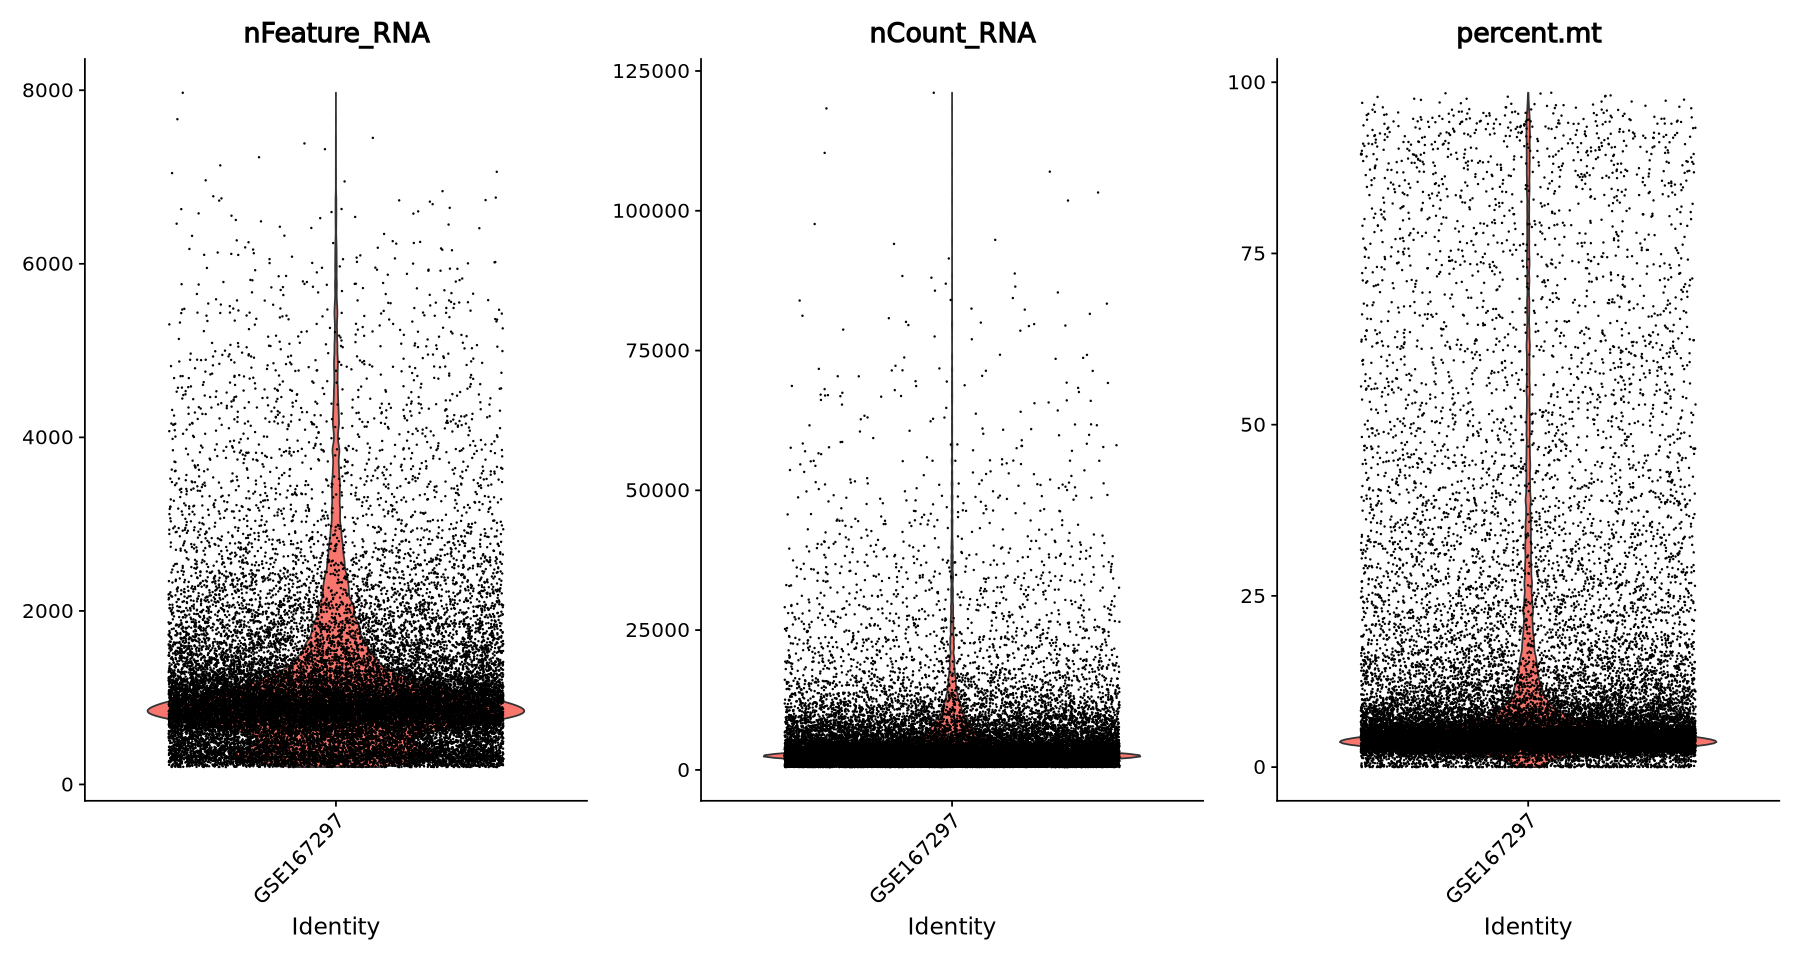

In [24]:
#QC Steps 
GC[["percent.mt"]] <- PercentageFeatureSet(GC, pattern = "^MT-")
#Visualise QC metrics
options(repr.plot.height=8, repr.plot.width=15)
VlnPlot(GC, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [25]:
#Normalise the data
GC <- NormalizeData(GC)
#Find variable features
GC <- FindVariableFeatures(GC, selection.method = "vst", nfeatures = 2000)
#Scale the data
GC <- ScaleData(GC, vars.to.regress = c("percent.mt", "nCount_RNA"))
#Run PCA
GC <- RunPCA(GC, features = VariableFeatures(object = GC))

Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Normalizing layer: counts.4

Normalizing layer: counts.5

Normalizing layer: counts.6

Normalizing layer: counts.7

Normalizing layer: counts.8

Normalizing layer: counts.9

Normalizing layer: counts.10

Normalizing layer: counts.11

Normalizing layer: counts.12

Normalizing layer: counts.13

Normalizing layer: counts.14

Finding variable features for layer counts.1

Finding variable features for layer counts.2

Finding variable features for layer counts.3

Finding variable features for layer counts.4

Finding variable features for layer counts.5

Finding variable features for layer counts.6

Finding variable features for layer counts.7

Finding variable features for layer counts.8

Finding variable features for layer counts.9

Finding variable features for layer counts.10

Finding variable features for layer counts.11

Finding variable features for layer counts.12

Finding variable features for laye

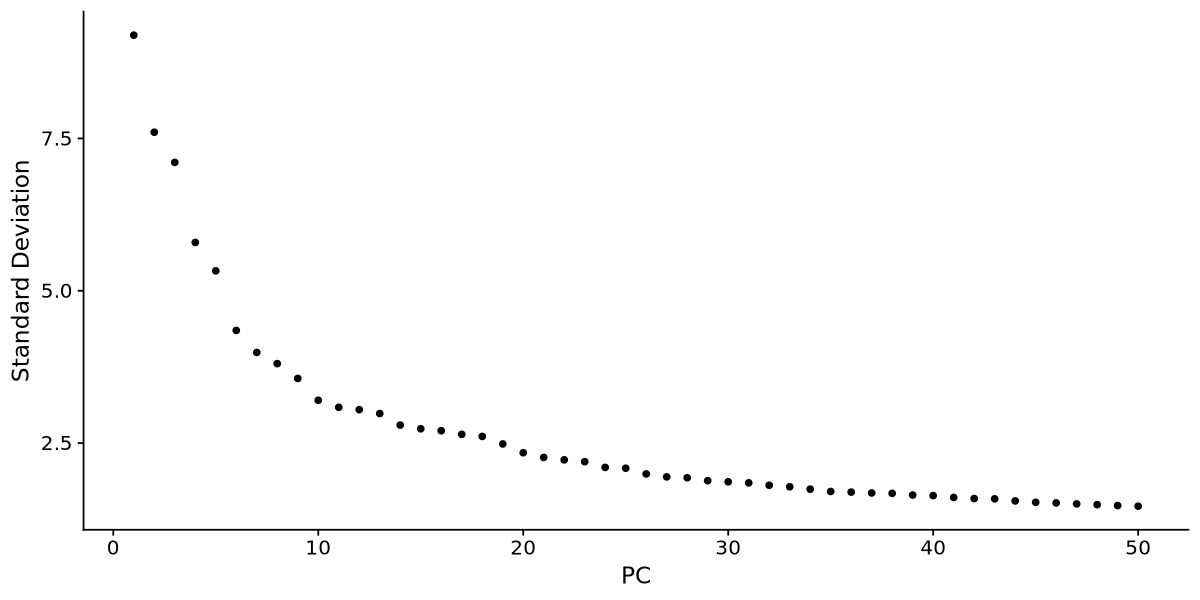

In [26]:
#make elbow plot
options(repr.plot.height=5, repr.plot.width=10)
ElbowPlot(GC, ndims=50)
#in GSE213243 decided to use 40 PC, staying consistent across datasets

In [27]:
#Find neighbours (make sure number matches no. features chosen above)
GC <- FindNeighbors(GC, dims = 1:40)

Computing nearest neighbor graph

Computing SNN



In [28]:
#Run UMAP
GC <- RunUMAP(GC, dims = 1:40)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:47:05 UMAP embedding parameters a = 0.9922 b = 1.112

15:47:05 Read 27073 rows and found 40 numeric columns

15:47:05 Using Annoy for neighbor search, n_neighbors = 30

15:47:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:47:07 Writing NN index file to temp file /scratch/temp/9533518/RtmpjymdO0/file1d3d11250ff485

15:47:07 Searching Annoy index using 1 thread, search_k = 3000

15:47:15 Annoy recall = 100%

15:47:15 Commencing smooth kNN distance calibration using 1 thread
 with 

In [29]:
#Cluster, resolution here set to 0.2
GC <- FindClusters(GC, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27073
Number of edges: 1016082

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9604
Number of communities: 12
Elapsed time: 4 seconds


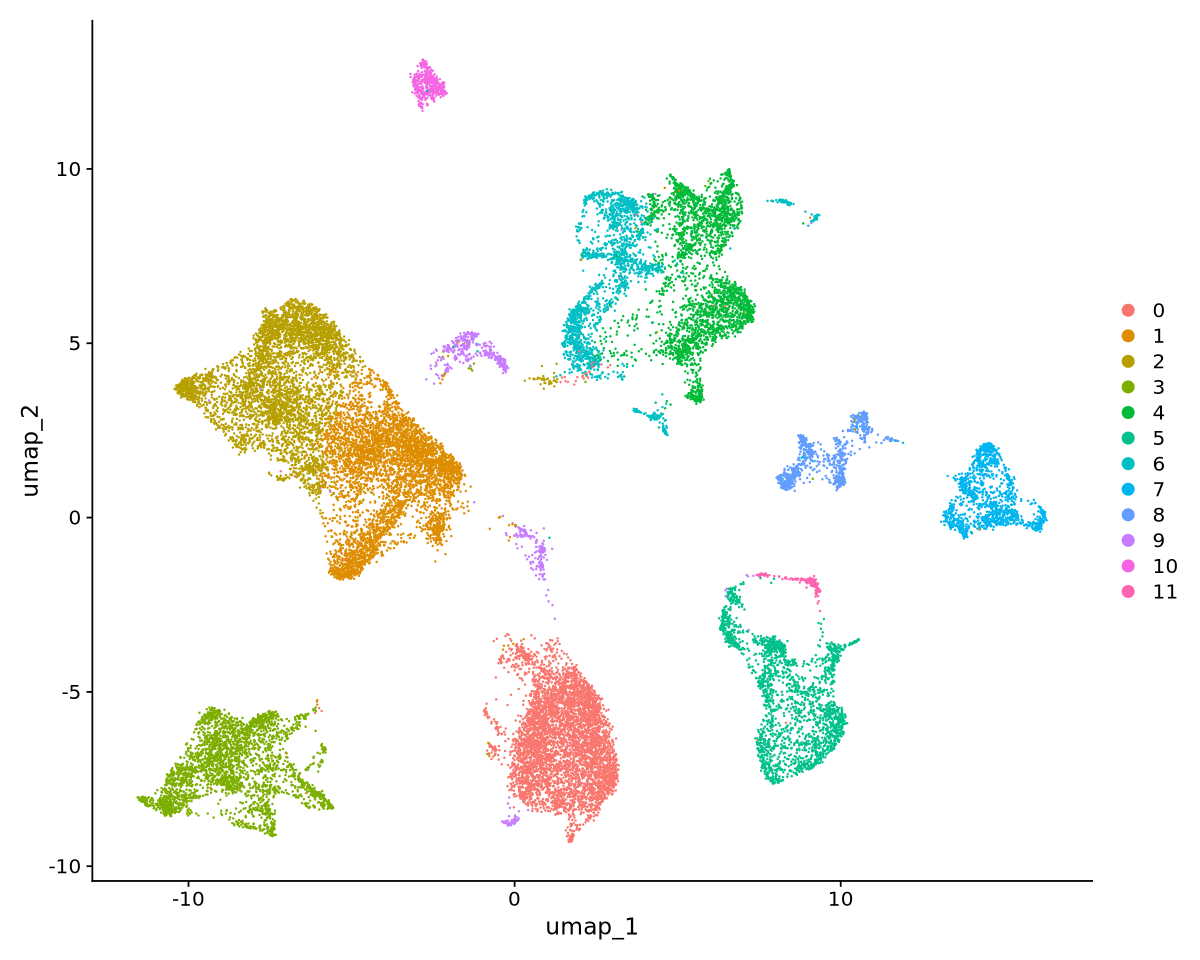

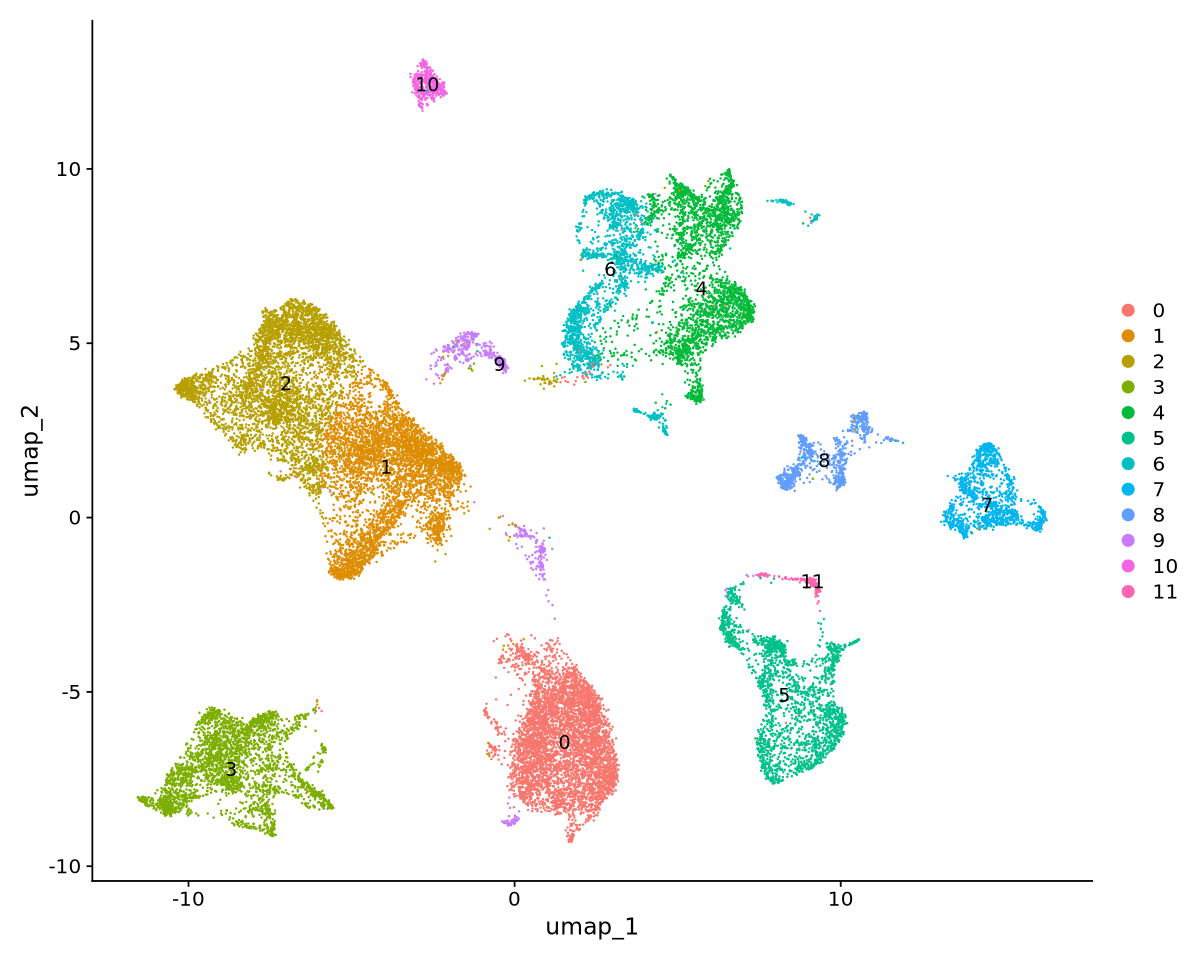

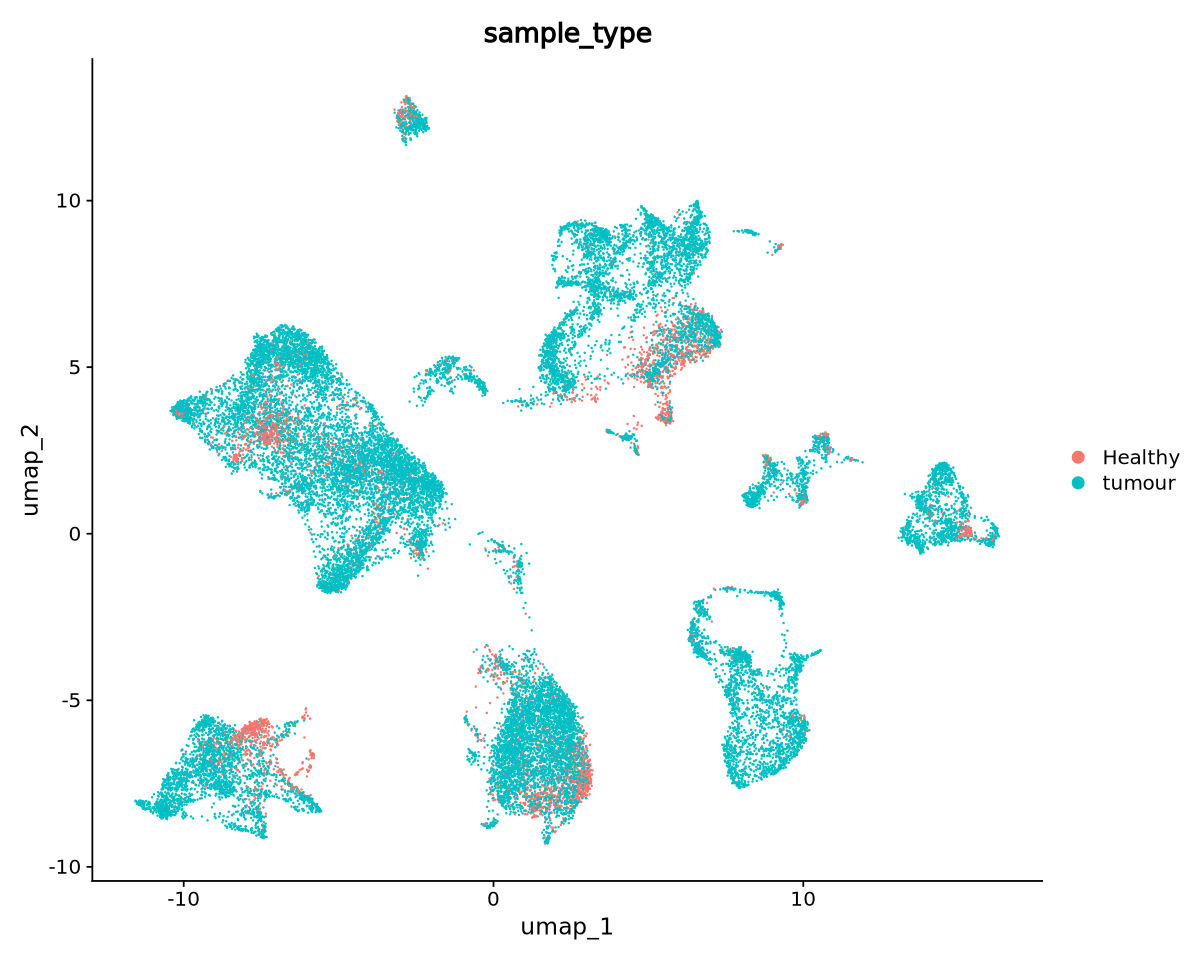

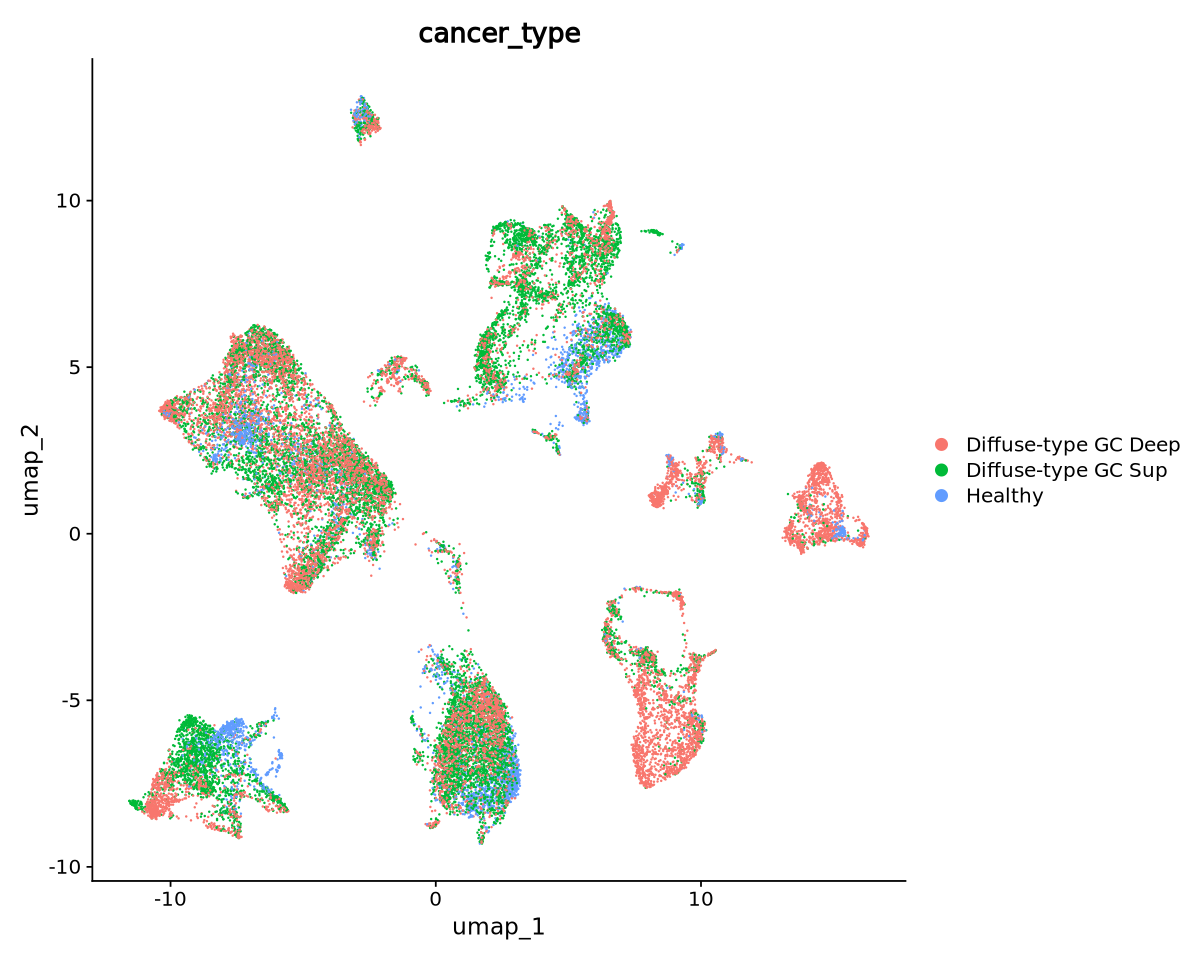

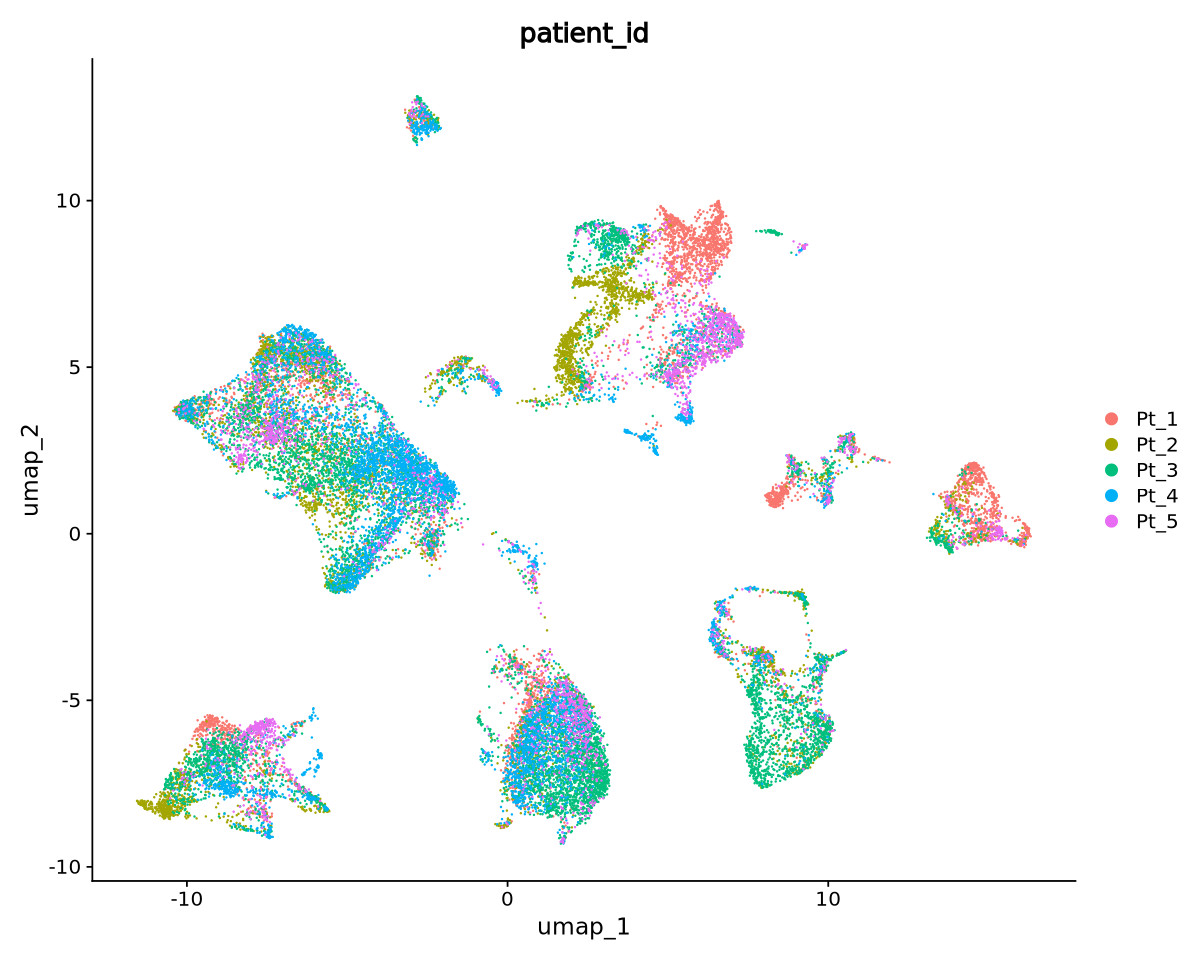

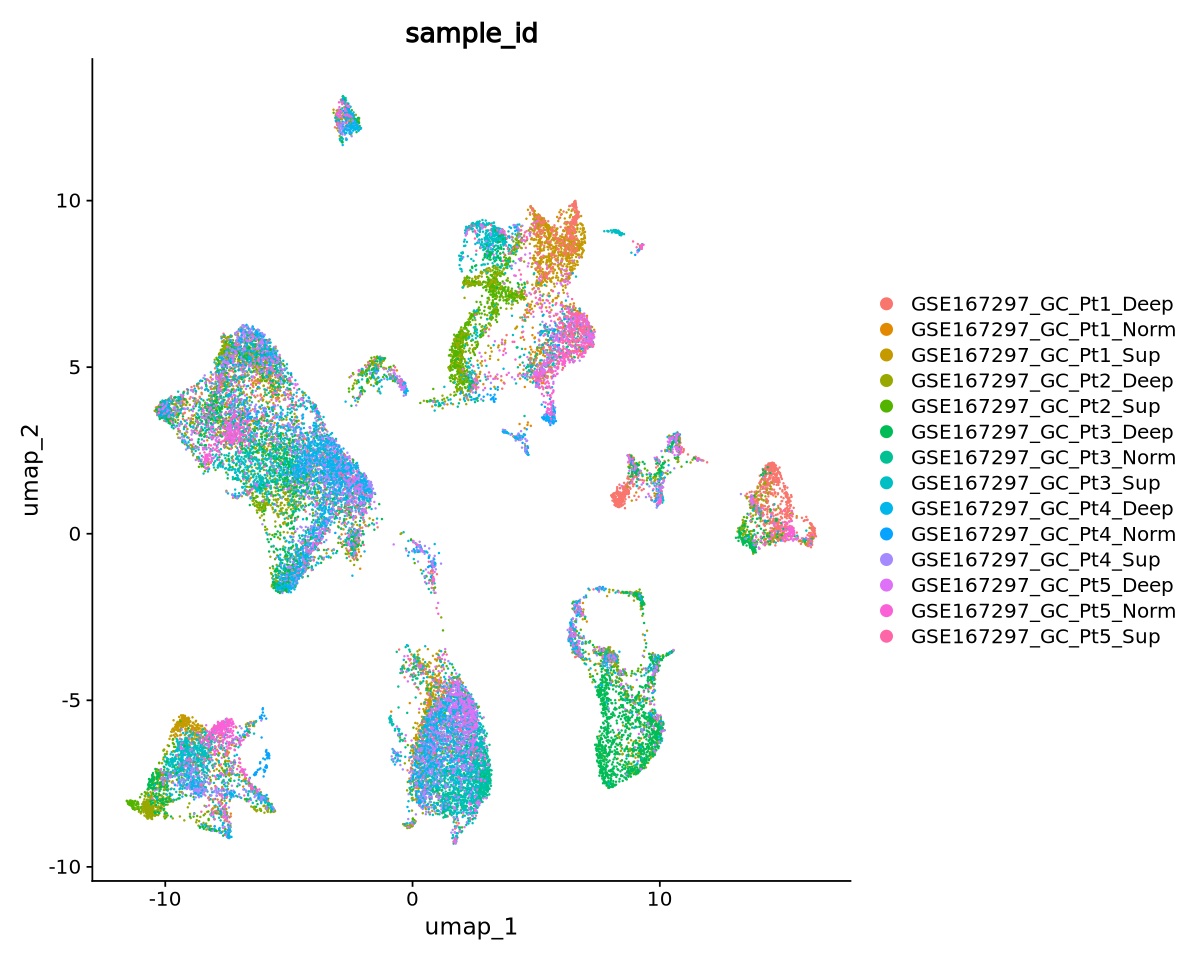

In [30]:
#Plot UMAP
options(repr.plot.height=8, repr.plot.width=10)
DimPlot(GC, reduction = "umap")
DimPlot(GC, reduction = "umap", label=TRUE)
DimPlot(GC, reduction = "umap", group = "sample_type")
DimPlot(GC, reduction = "umap", group = "cancer_type")
DimPlot(GC, reduction = "umap", group = "patient_id")
DimPlot(GC, reduction = "umap", group = "sample_id")

In [32]:
#Save the object at this point so it can be loaded in without running steps above
saveRDS(GC, file = "/scratch/user/s4436039/scdata/GSE167297/GSE167297.RDS")

#### Next part of code is about determining which cluster is the myeloid cells

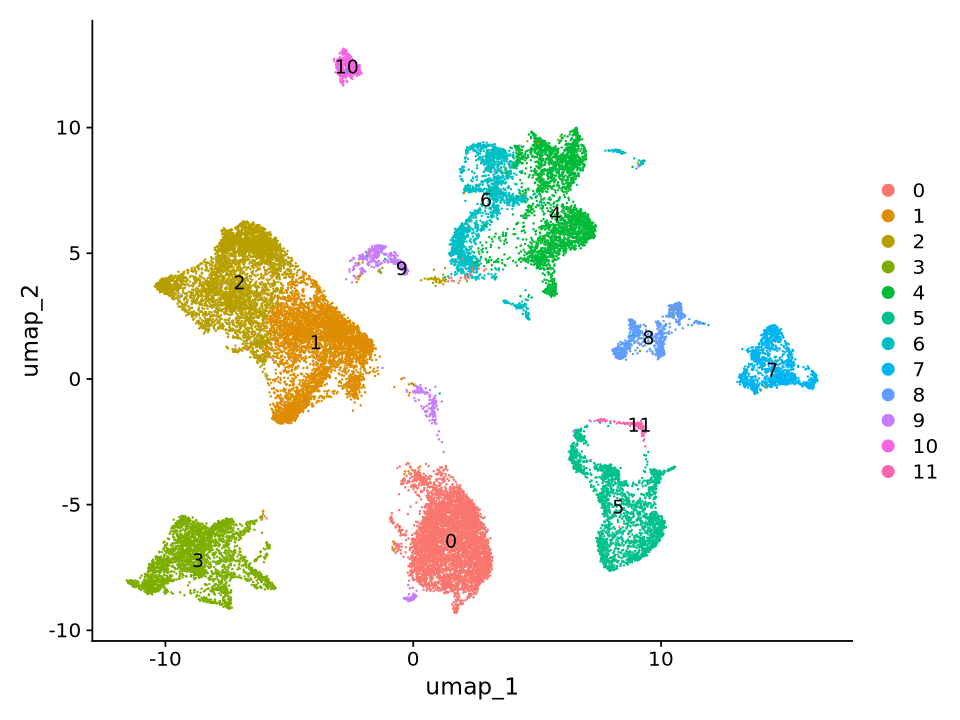

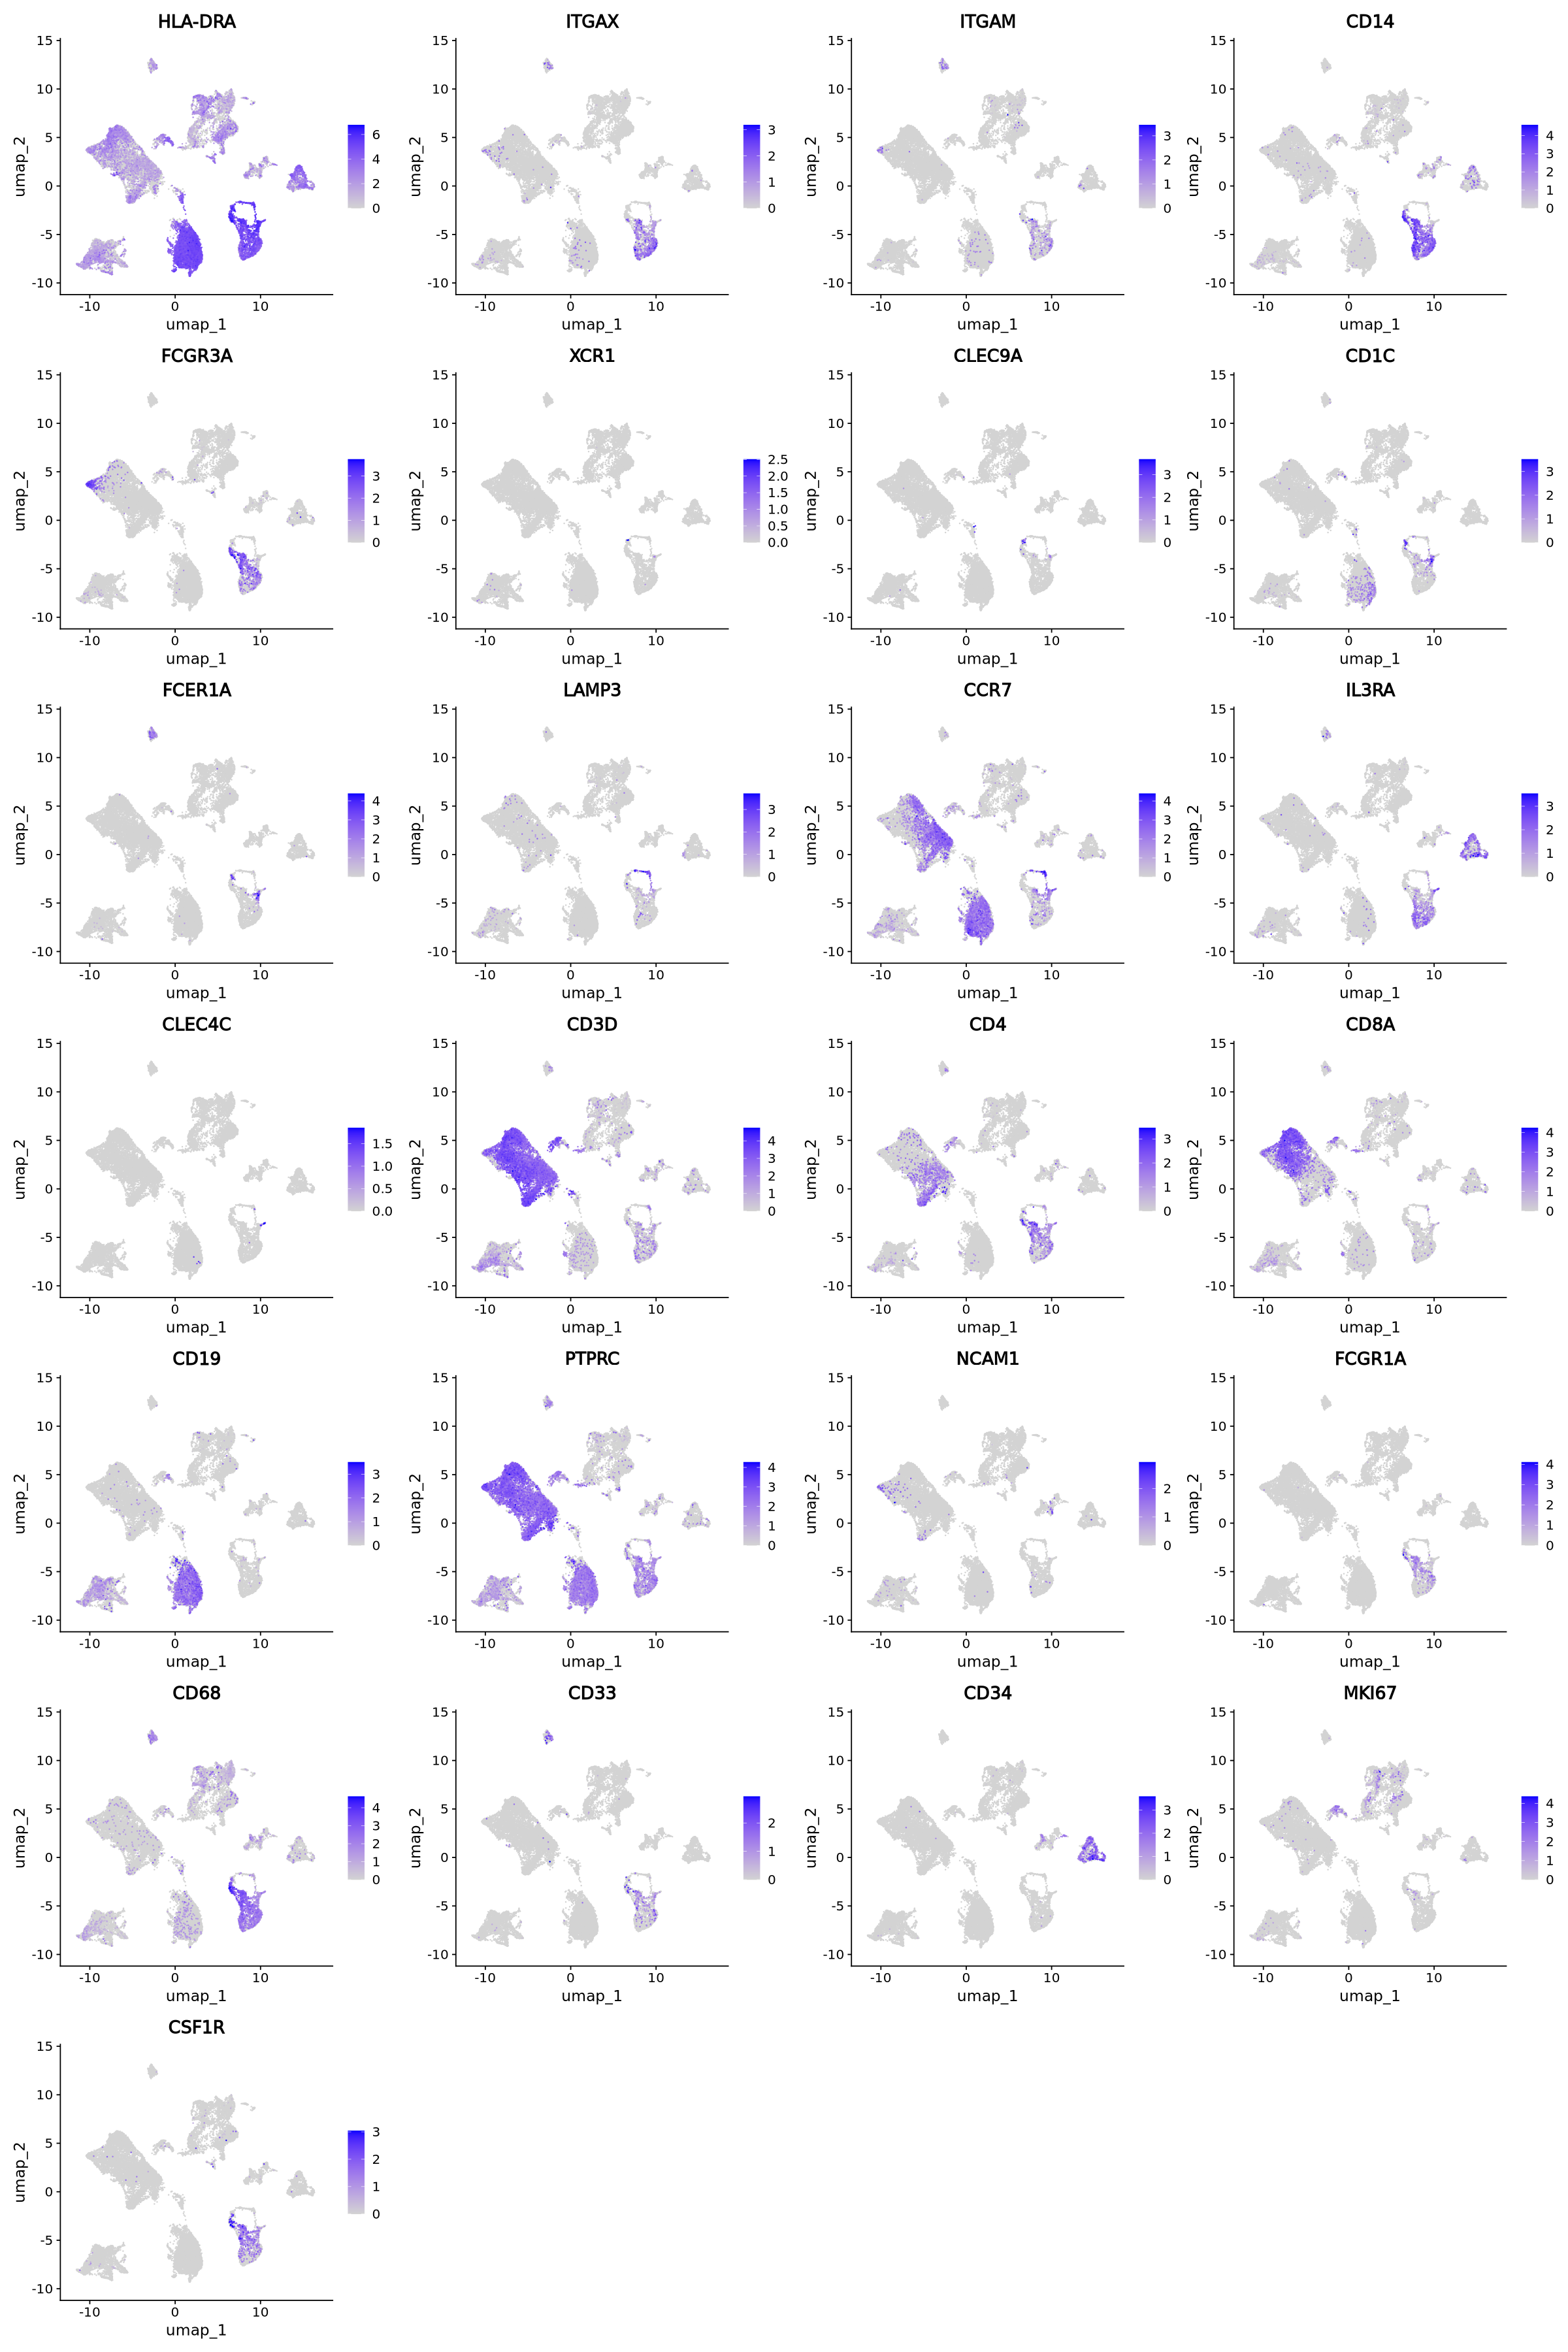

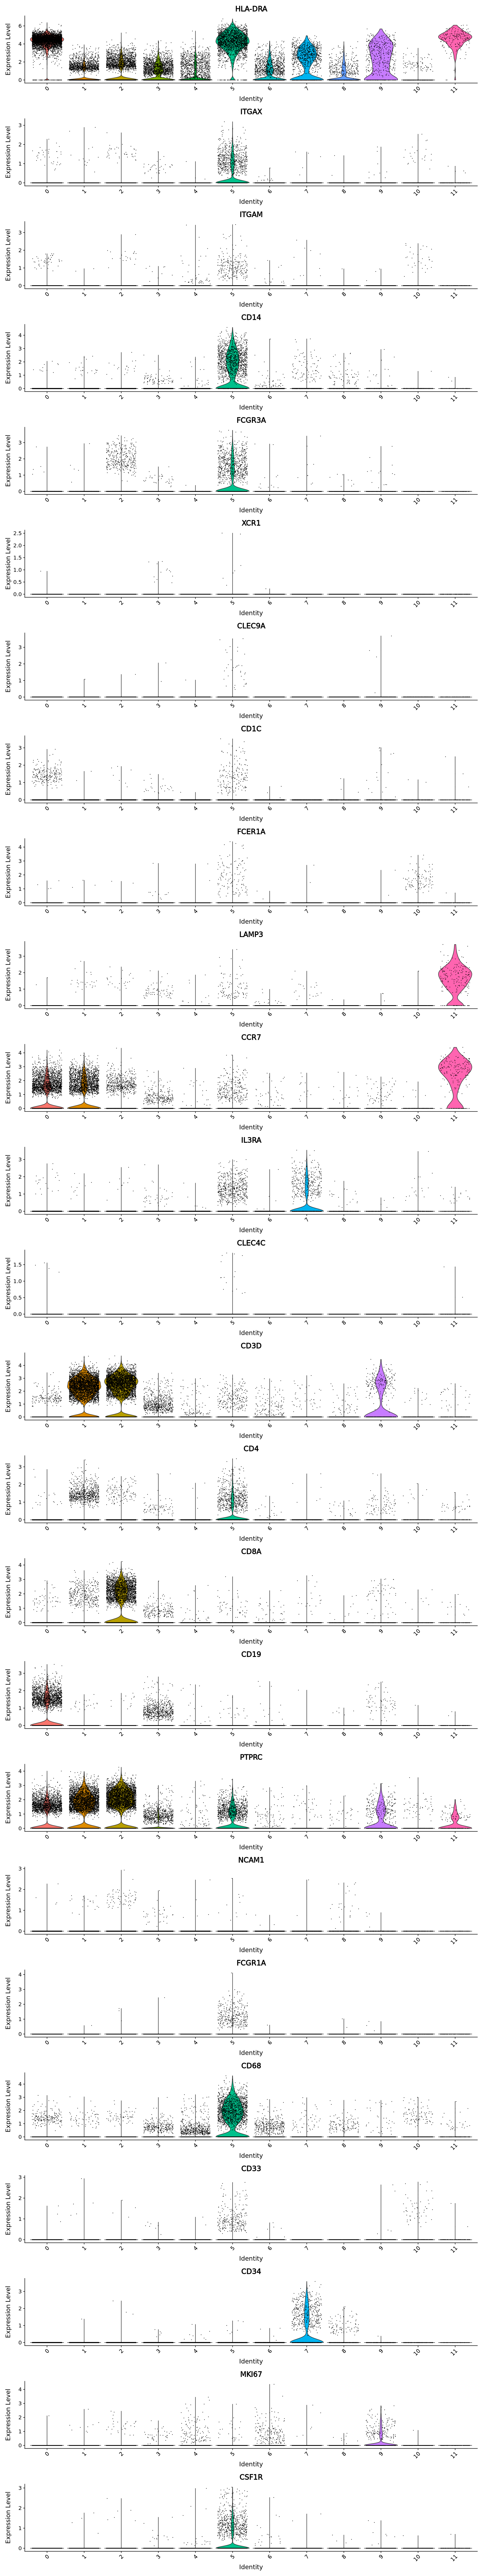

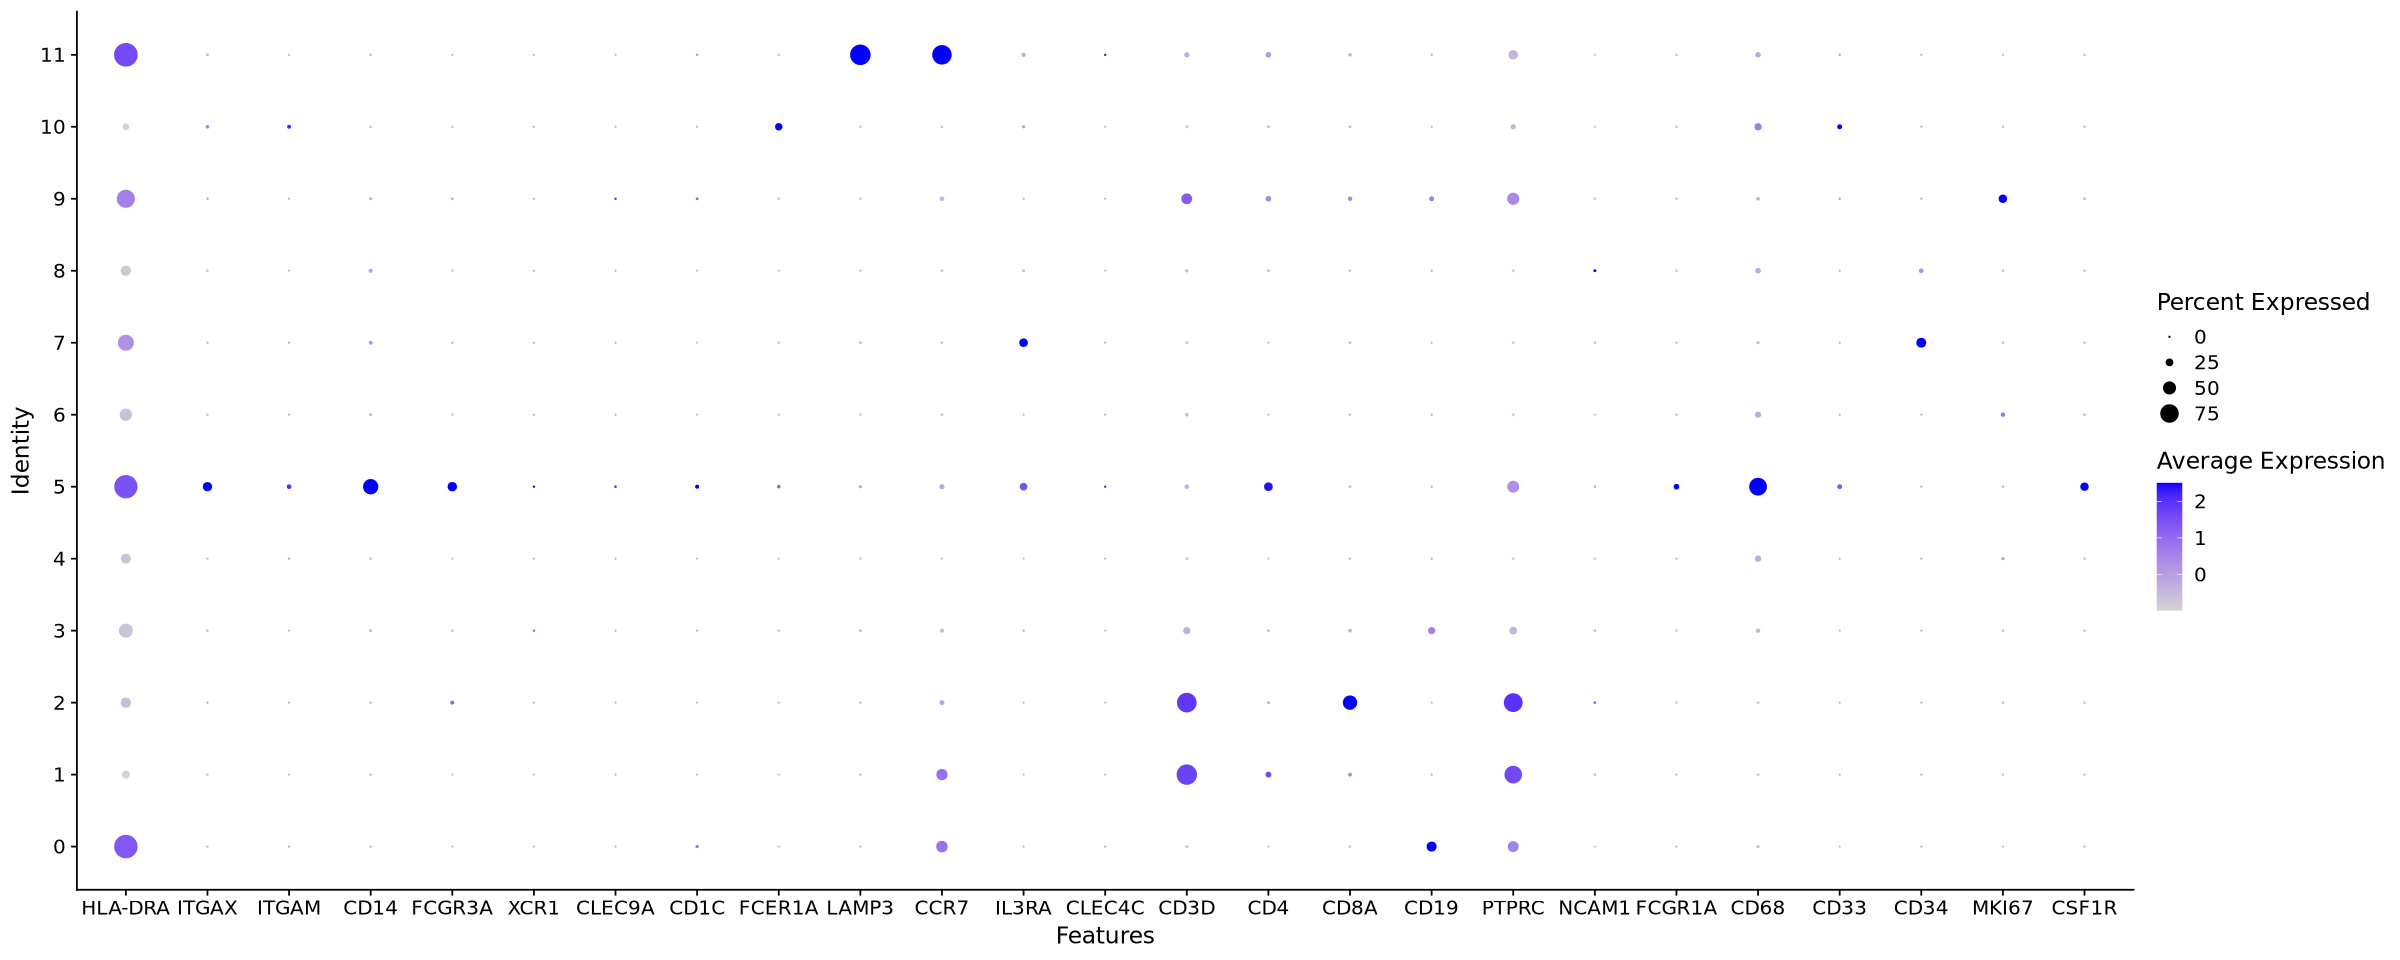

In [33]:
#Same genes over UMAP
options(repr.plot.height=6, repr.plot.width=8)
DimPlot(GC, reduction = "umap", label=TRUE)

options(repr.plot.height=30, repr.plot.width=20)
FeaturePlot(GC, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"), order = TRUE)

#Violin plots of classic markers
options(repr.plot.height=80, repr.plot.width=15)
VlnPlot(GC, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"), ncol=1)

#Same as above but dot plot
options(repr.plot.height=8, repr.plot.width=20)
DotPlot(GC, features = c("HLA-DRA", "ITGAX", "ITGAM", "CD14", "FCGR3A", "XCR1", "CLEC9A", "CD1C", "FCER1A", "LAMP3", "CCR7", "IL3RA", "CLEC4C", "CD3D", "CD4", "CD8A", "CD19", "PTPRC", "NCAM1", "FCGR1A", "CD68", "CD33", "CD34", "MKI67", "CSF1R"))

#### From above it looks like clusters 5 and 11 are the myeloid cells, now subsetting out these clusters

In [34]:
head(GC@meta.data)

orig.ident nCount_RNA nFeature_RNA
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 GSE167297   1037       368        
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 GSE167297    513       265        
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 GSE167297  91470      6344        
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 GSE167297    690       245        
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 GSE167297    584       278        
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 GSE167297   2073       602        
                                         sample_type cancer_type patient_id
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 Healthy     Healthy     Pt_1      
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 Healthy     Healthy     Pt_1      
                                         sample_id             percent.mt
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 GSE167297_GC_Pt1_Norm  2.700096 
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 GSE167297_GC_Pt1_Norm 25.536062 
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 GSE167297_GC_Pt1_Norm  9.663278 
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 GSE167297_GC_Pt1_Norm 35.362319 
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 GSE167297_GC_Pt1_Norm 23.972603 
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 GSE167297_GC_Pt1_Norm 39.990352 
                                         RNA_snn_res.0.2 seurat_clusters
GSE167297_GC_Pt1_Norm_AAACCTGGTTTGACTG-1 4               4              
GSE167297_GC_Pt1_Norm_AAACGGGCAGACGTAG-1 4               4              
GSE167297_GC_Pt1_Norm_AAAGATGAGTACGTAA-1 3               3              
GSE167297_GC_Pt1_Norm_AAAGCAAGTCAGAATA-1 0               0              
GSE167297_GC_Pt1_Norm_AAAGCAAGTCGGATCC-1 1               1              
GSE167297_GC_Pt1_Norm_AAAGTAGCAACGATGG-1 1               1

In [35]:
myeloid_GC <- subset(GC, subset = RNA_snn_res.0.2 %in% c("5","11"))

In [36]:
GC
myeloid_GC

An object of class Seurat 
32738 features across 27073 samples within 1 assay 
Active assay: RNA (32738 features, 2000 variable features)
 29 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, data.1, data.2, data.3, data.4, data.5, data.6, data.7, data.8, data.9, data.10, data.11, data.12, data.13, data.14, scale.data
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
32738 features across 2369 samples within 1 assay 
Active assay: RNA (32738 features, 2000 variable features)
 29 layers present: counts.1, counts.2, counts.3, counts.4, counts.5, counts.6, counts.7, counts.8, counts.9, counts.10, counts.11, counts.12, counts.13, counts.14, data.1, data.2, data.3, data.4, data.5, data.6, data.7, data.8, data.9, data.10, data.11, data.12, data.13, data.14, scale.data
 2 dimensional reductions calculated: pca, umap

In [37]:
saveRDS(myeloid_GC, "/scratch/user/s4436039/scdata/GSE167297/GSE167297_myeloid.RDS")

#### Following the above then need to move entire GSE224090 folder from scratch to rdm
``` bash
rsync -azvhp /scratch/user/s4436039/scdata/GSE167297/ /QRISdata/Q5935/nikita/scdata/GSE167297
```